# Environment

In [1]:
# !conda update -n base -c conda-forge conda -y
# !conda install -n pytorch_p310 -c conda-forge "cuda-version=12.5" "cudnn=9.3.*" -y
# !python -m pip install --upgrade pip setuptools wheel
# !pip install --upgrade tensorflow==2.19.1 keras==3.6.0 ml-dtypes==0.5.1 keras-hub --only-binary=:all:
# !pip install wordcloud keras-cv keras-nlp focal-loss tfclip tensorflow-hub tensorflow-text optuna ftfy albumentationsx

In [2]:
import os, sys
import tensorflow as tf

# Prepend conda lib path so TF sees the newly installed cuDNN
conda_env = "pytorch_p310"
try:
    import subprocess, json
    envs = subprocess.check_output(["conda", "env", "list", "--json"]).decode()
    envs = json.loads(envs)
    lib_path = None
    for p in envs.get("envs", []):
        if p.endswith(conda_env):
            lib_path = os.path.join(p, "lib")
            break
    if lib_path and os.path.isdir(lib_path):
        os.environ["LD_LIBRARY_PATH"] = lib_path + os.pathsep + os.environ.get("LD_LIBRARY_PATH", "")
except Exception:
    pass

print("Visible GPUs:", tf.config.list_physical_devices("GPU"))

# Try a quick cuDNN op to confirm
try:
    with tf.device("GPU:0"):
        x = tf.random.normal([1, 32, 224, 224, 3])
        x = tf.reduce_mean(x)
    print("TF OK on GPU; cuDNN likely loaded.")
except Exception as e:
    print("GPU/cuDNN check failed:", e)


2025-10-10 00:32:59.262198: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-10 00:32:59.279260: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760056379.299476   22896 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760056379.305714   22896 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760056379.321293   22896 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TF OK on GPU; cuDNN likely loaded.


I0000 00:00:1760056383.270982   22896 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13760 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5


In [3]:
import os
import tensorflow as tf
from tfclip import create_model_and_transforms

# Ensure GPU is visible
print("GPUs:", tf.config.list_physical_devices("GPU"))
assert tf.config.list_physical_devices("GPU"), "No GPU detected by TensorFlow."

# Limit memory growth to avoid OOMs
for gpu in tf.config.list_physical_devices("GPU"):
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
    except Exception:
        pass

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# !pip install tfclip ftfy

In [5]:
# !python -m pip install --upgrade pip setuptools wheel
# !pip install --upgrade tensorflow==2.19.1 keras==3.6.0 ml-dtypes==0.5.1 tfclip --only-binary=:all:

In [6]:
# !pip install wordcloud tfclip tensorflow-hub tensorflow-text optuna ftfy albumentationsx

In [7]:
# !pip install --upgrade keras-hub

In [8]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"  # must be set BEFORE importing keras/*

In [9]:
import tensorflow as tf
import keras
# import keras_hub

# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# List all physical devices
print("\nAll devices:")
print(tf.config.list_physical_devices())

Num GPUs Available:  1

All devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [10]:
import os, json, hashlib, random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from wordcloud import WordCloud, STOPWORDS

print("TF:", tf.__version__)

TF: 2.19.1


In [11]:
# Repro
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)


# Paths & Load data

In [12]:
DATA_DIR = "./A2_Data"
JSONL   = os.path.join(DATA_DIR, "A2_train_v3.jsonl")
IMAGE_DIR = os.path.join(DATA_DIR, "A2_Images")
df = pd.read_json(JSONL, lines=True)
assert set(["Image_ID","Label","Hypothesis","Premise"]).issubset(df.columns), df.columns

# Resolve image paths (try common extensions)
EXTS = [".jpg", ".jpeg", ".png", ".JPG", ".PNG"]
def resolve_image_path(image_id, root=IMAGE_DIR, exts=EXTS):
    sid = str(image_id).strip()
    for e in exts:
        p = os.path.join(root, sid + e)
        if os.path.isfile(p):
            return p
    return None


In [13]:
# e.g. sample 20% from each label
# df = df.groupby("Label", group_keys=False).apply(lambda x: x.sample(frac=0.3, random_state=42))


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39129 entries, 0 to 39128
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Image_ID    39129 non-null  int64 
 1   Label       39129 non-null  object
 2   Hypothesis  39129 non-null  object
 3   Premise     39129 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


In [15]:
df["image_path"] = df["Image_ID"].apply(resolve_image_path)
missing_before = df["image_path"].isna().sum()
if missing_before:
    print(f"[WARN] {missing_before} rows have no matching image file. Dropping them.")
df = df.dropna(subset=["image_path"]).reset_index(drop=True)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39129 entries, 0 to 39128
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Image_ID    39129 non-null  int64 
 1   Label       39129 non-null  object
 2   Hypothesis  39129 non-null  object
 3   Premise     39129 non-null  object
 4   image_path  39129 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.5+ MB


# Exploratory Data Analysis

In [17]:
import os, re, math, random, hashlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image, ImageOps

# Optional deep EDA (text+image similarity)
DO_DEEP_SIM = True
try:
    import tensorflow as tf, tensorflow_hub as hub, tensorflow_text  # noqa
    # import keras_hub as kh
except Exception:
    DO_DEEP_SIM = False
    print("[INFO] Deep similarity (USE/CLIP) disabled — missing TF deps. Install if you want those plots.")

# -----------------------
# Config
# -----------------------
DATA_FILE   = "./A2_Data/train.csv"     # accepts .csv, .tsv, .jsonl
IMAGE_ROOT  = "./A2_Data/A2_Images"
SEED = 42
BATCH_SIZE = 64
random.seed(SEED); np.random.seed(SEED)

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/tensorflow_hub/__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


In [18]:
# Optional deep EDA (text+image similarity)
import os

def count_images(root_dir, exts=None, show_breakdown=True):
    """
    Recursively count image files in `root_dir`.

    Args:
        root_dir (str): Path to scan.
        exts (list[str] | None): Allowed extensions (case-insensitive).
                                 Defaults to common image formats.
        show_breakdown (bool): Whether to print counts per extension.

    Returns:
        total (int): Total number of image files found.
    """
    if exts is None:
        exts = [".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".gif", ".webp"]

    # Normalize to lowercase for matching
    exts = [e.lower() for e in exts]
    counts = {e: 0 for e in exts}
    total = 0

    for root, _, files in os.walk(root_dir):
        for f in files:
            _, ext = os.path.splitext(f)
            ext = ext.lower()
            if ext in exts:
                counts[ext] += 1
                total += 1

    if show_breakdown:
        print(f"\nImage counts under: {root_dir}")
        for e, c in counts.items():
            print(f"  {e:>6}: {c}")
        print(f"  Total: {total}")

    return total

total = count_images(IMAGE_ROOT)
print(f"\nTotal images found: {total}")



Image counts under: ./A2_Data/A2_Images
    .jpg: 19573
   .jpeg: 0
    .png: 0
    .bmp: 0
   .tiff: 0
    .gif: 0
   .webp: 0
  Total: 19573

Total images found: 19573


In [19]:
df["Label"] = df["Label"].astype(str).str.strip().str.lower()
valid_labels = {"entailment","contradiction","neutral"}
unknown = set(df["Label"].unique()) - valid_labels
if unknown:
    print("[WARN] Found unknown labels:", unknown)

# Stable label map
label_names = sorted([l for l in df["Label"].unique() if l in valid_labels])
label2id = {n:i for i,n in enumerate(label_names)}
df["label_id"] = df["Label"].map(label2id)

In [20]:
def show_bar(series, title, xlabel, ylabel="Count", rot=45, figsize=(7,4)):
    plt.figure(figsize=figsize)
    series.plot(kind="bar")
    plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.xticks(rotation=rot); plt.tight_layout(); plt.show()

def simple_tokenize(s):
    return [t for t in re.split(r"[^a-z0-9]+", str(s).lower()) if t]

def negation_count(s):
    # crude but useful: captures typical negation cues
    terms = ["no","not","never","none","nobody","nothing","nowhere","neither","nor","cannot","can't","won't","n't"]
    toks = simple_tokenize(s)
    return sum(tok in terms for tok in toks)


[EDA] Label distribution
Label
entailment       19619
contradiction    19510
Name: count, dtype: int64


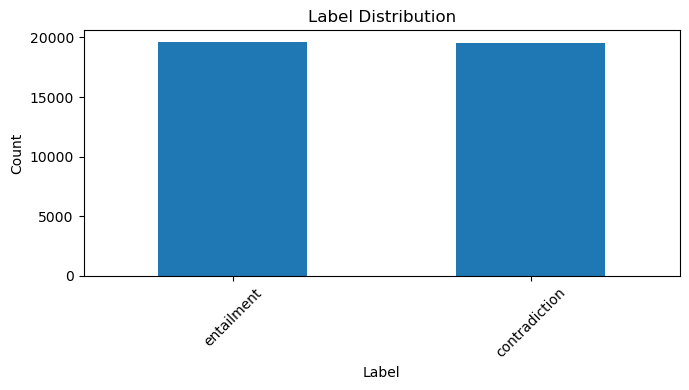

Imbalance ratio (max/min): 1.01


In [21]:
print("\n[EDA] Label distribution")
lbl_counts = df["Label"].value_counts()
print(lbl_counts)
show_bar(lbl_counts, "Label Distribution", "Label")
print(f"Imbalance ratio (max/min): {lbl_counts.max()/max(1,lbl_counts.min()):.2f}")

In [22]:
print("\n[EDA] Conflicting labels for the SAME Image_ID")
conflict_counts = (
    df.groupby("Image_ID")["Label"]
      .nunique()
      .reset_index(name="n_labels")
      .query("n_labels > 1")
)
print(f"Images with multiple labels: {len(conflict_counts)}")
if len(conflict_counts):
    # Show a few examples with all their rows
    sample_ids = conflict_counts["Image_ID"].head(3).tolist()
    print("\nExamples (first 3 Image_IDs with conflicts):")
    print(df[df["Image_ID"].isin(sample_ids)]
          .sort_values(["Image_ID","Label"])
          [["Image_ID","Label","Hypothesis","Premise"]]
          .head(12)
          .to_string(index=False))


[EDA] Conflicting labels for the SAME Image_ID
Images with multiple labels: 8945

Examples (first 3 Image_IDs with conflicts):
 Image_ID         Label                                        Hypothesis                                                                                                           Premise
    36979 contradiction      The students are walking down a busy street.                                                  A group of college students gathers to play texas hold em poker.
    36979    entailment                       People playing a card game.                   A group of friends playing cards and trying to bluff each other into making a terrible mistake.
   178045 contradiction A crowd watches at the magician performs his act.                                                A group of traditional Mexican dancers twirl their flowing skirts.
   178045    entailment     A group of dancers are twirling their skirts.                                               

### Duplicates Leakage Check

In [23]:
import pandas as pd
from tqdm import tqdm
import hashlib

# 1️⃣ Compute MD5 hashes if you haven’t already
def md5_file(path, chunk_size=8192):
    try:
        h = hashlib.md5()
        with open(path, "rb") as f:
            while chunk := f.read(chunk_size):
                h.update(chunk)
        return h.hexdigest()
    except Exception as e:
        return None  # missing / unreadable file

if "image_md5" not in df.columns:
    tqdm.pandas(desc="Hashing images")
    df["image_md5"] = df["image_path"].astype(str).progress_apply(md5_file)

# 2️⃣ Find groups of identical hashes with different Image_IDs
dupe_groups = (
    df.groupby("image_md5")
      .agg({"Image_ID": pd.Series.nunique, "image_path": list})
      .reset_index()
)

# Keep only those where multiple Image_IDs share same hash
dupe_groups = dupe_groups[dupe_groups["Image_ID"] > 1]

print(f"🧩 Found {len(dupe_groups)} duplicate hash groups (same image, different ID)")

# 3️⃣ For each hash, print which Image_IDs share it
for _, row in dupe_groups.iterrows():
    md5 = row["image_md5"]
    # subset rows that share this hash
    subset = df[df["image_md5"] == md5][["Image_ID", "image_path"]].drop_duplicates()
    print("\n🔁 Duplicate image content group:")
    print(f"Hash: {md5}")
    print(subset.to_string(index=False))

Hashing images: 100%|██████████| 39129/39129 [00:09<00:00, 3918.51it/s]


🧩 Found 0 duplicate hash groups (same image, different ID)


In [24]:
import pandas as pd

# 1️⃣ Count how many times each Image_ID appears
img_counts = (
    df["Image_ID"]
    .value_counts()
    .reset_index()
    .rename(columns={"index": "Image_ID", "Image_ID": "count"})
)

# 2️⃣ Keep only images used more than once
reused = img_counts[img_counts["count"] > 1]

print(f"🧩 Found {len(reused)} images used multiple times (total rows: {len(df)})")
print(reused.dropna()) 

🧩 Found 19573 images used multiple times (total rows: 39129)
            count  count
0      2572812372    3.0
1      3372351555    3.0
2      4564320256    3.0
3      3470718914    3.0
4      1931018353    3.0
...           ...    ...
13064  2494562446    2.0
13065  3936944273    2.0
13066  3135504530    2.0
13067  4329504863    2.0
13068  3209350613    2.0

[13069 rows x 2 columns]


In [25]:
# import pandas as pd

# # Define the columns that define a "record"
# #    (change these if your key is different)
# key_cols = ["Image_ID", "Premise", "Hypothesis", "Label"]


# # Detect duplicates — keep=False marks *all* occurrences
# df_clean["is_duplicate"] = df_clean.duplicated(subset=key_cols, keep=False)

# # 4️⃣ Subset only duplicated records
# duplicates_df = df_clean[df_clean["is_duplicate"]].copy()

# # 5️⃣ Count unique duplicated groups
# dupe_groups = (
#     duplicates_df.groupby(key_cols)
#     .size()
#     .reset_index(name="duplicate_count")
#     .sort_values("duplicate_count", ascending=False)
# )

# # 🧾 Summary
# print(f"🧩 Total rows in df: {len(df)}")
# print(f"🔁 Total duplicated rows: {len(duplicates_df)}")
# print(f"📦 Unique duplicate groups: {len(dupe_groups)}")

# # 6️⃣ Show top duplicate groups
# print("\n🔍 Top duplicate groups (same record repeated):")
# print(dupe_groups.head(10))

# # 7️⃣ Optional: inspect all duplicates side by side
# if not duplicates_df.empty:
#     print("\n🔁 All duplicate rows (full details):")
#     print(duplicates_df.sort_values(key_cols).head(20))


### Word Clouds for Text Analysis

Visualizing the most frequent words in premise and hypothesis texts to understand common themes and patterns.

🔍 Generating Word Clouds for Text Analysis


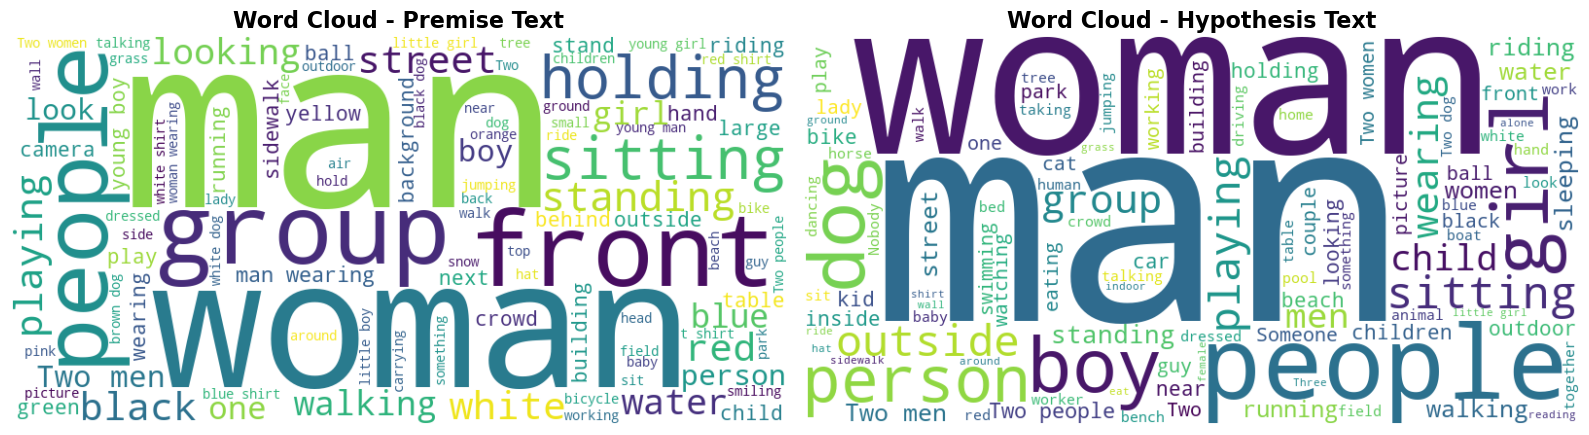


📊 Word Clouds by Label (Hypothesis)


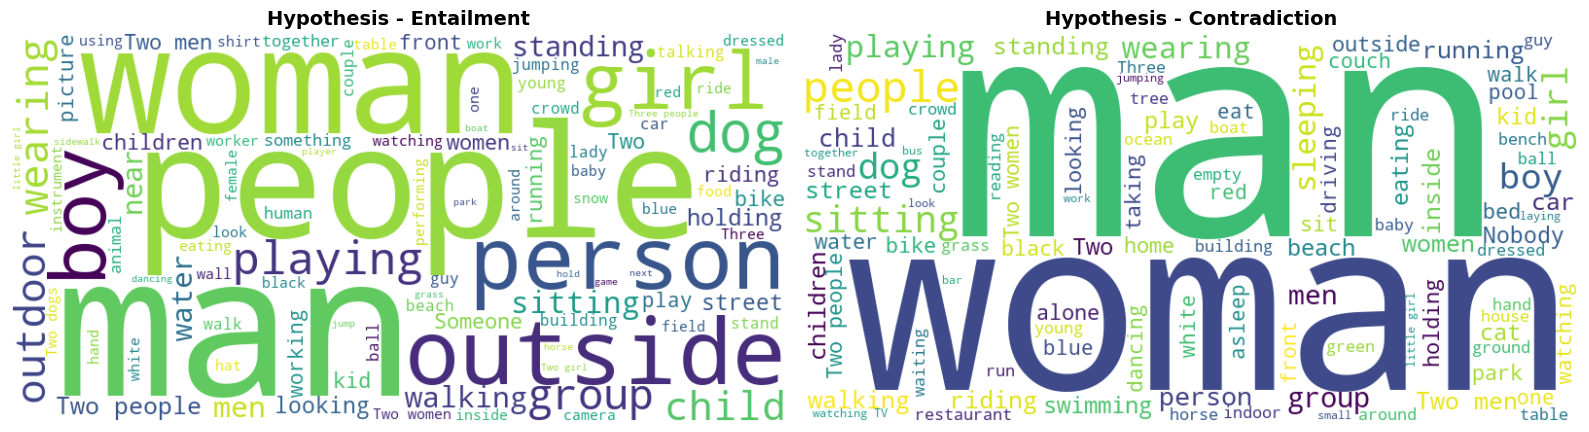

In [26]:
# Word Cloud EDA for Premise and Hypothesis
print("🔍 Generating Word Clouds for Text Analysis")

# Combine all premise texts and hypothesis texts
premise_text = ' '.join(df['Premise'].astype(str).tolist())
hypothesis_text = ' '.join(df['Hypothesis'].astype(str).tolist())

# Create word clouds with custom settings
wordcloud_settings = {
    'width': 800,
    'height': 400,
    'background_color': 'white',
    'stopwords': STOPWORDS,
    'max_words': 100,
    'colormap': 'viridis',
    'contour_width': 1,
    'contour_color': 'steelblue'
}

# Generate word cloud for Premise
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
wc_premise = WordCloud(**wordcloud_settings).generate(premise_text)
plt.imshow(wc_premise, interpolation='bilinear')
plt.title('Word Cloud - Premise Text', fontsize=16, fontweight='bold')
plt.axis('off')

# Generate word cloud for Hypothesis
plt.subplot(1, 2, 2)
wc_hypothesis = WordCloud(**wordcloud_settings).generate(hypothesis_text)
plt.imshow(wc_hypothesis, interpolation='bilinear')
plt.title('Word Cloud - Hypothesis Text', fontsize=16, fontweight='bold')
plt.axis('off')

plt.tight_layout()
plt.show()

# Optional: Word clouds by label for hypothesis
print("\n📊 Word Clouds by Label (Hypothesis)")

# Get unique labels
labels = df['Label'].unique()

# Create word clouds for each label
fig, axes = plt.subplots(1, len(labels), figsize=(16, 6))

for i, label in enumerate(labels):
    # Filter hypothesis text by label
    hypo_by_label = df[df['Label'] == label]['Hypothesis'].astype(str).tolist()
    hypo_text_by_label = ' '.join(hypo_by_label)

    # Generate word cloud
    wc_label = WordCloud(**wordcloud_settings).generate(hypo_text_by_label)
    axes[i].imshow(wc_label, interpolation='bilinear')
    axes[i].set_title(f'Hypothesis - {label.title()}', fontsize=14, fontweight='bold')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### Text stats & cues


[EDA] Text length — Premise
Chars: count    39129.00
mean        64.60
std         27.86
min         10.00
25%         45.00
50%         59.00
75%         78.00
max        339.00
Words: count    39129.00
mean        12.62
std          5.42
min          2.00
25%          9.00
50%         12.00
75%         15.00
max         64.00


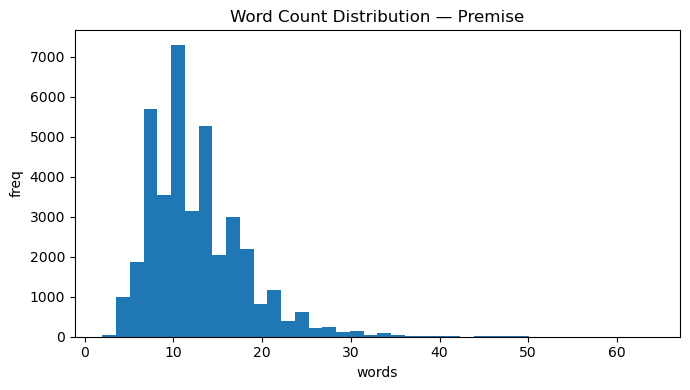


[EDA] Text length — Hypothesis
Chars: count    39129.00
mean        34.87
std         14.04
min          1.00
25%         25.00
50%         32.00
75%         41.00
max        204.00
Words: count    39129.00
mean         6.95
std          2.75
min          1.00
25%          5.00
50%          6.00
75%          8.00
max         35.00


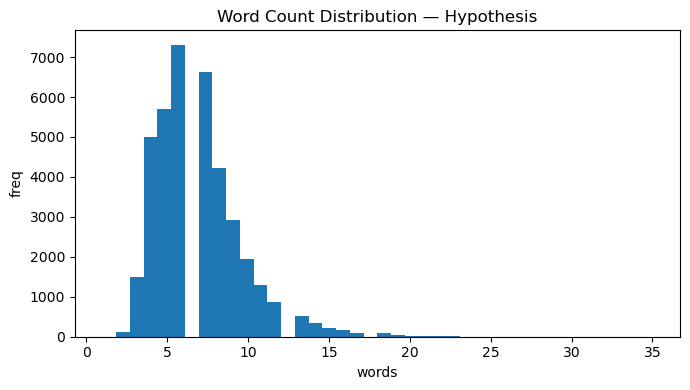

In [27]:
for col in ["Premise","Hypothesis"]:
    print(f"\n[EDA] Text length — {col}")
    lengths = df[col].astype(str).map(lambda s: len(s))
    words   = df[col].astype(str).map(lambda s: len(simple_tokenize(s)))
    print("Chars:", lengths.describe().round(2).to_string())
    print("Words:", words.describe().round(2).to_string())
    plt.figure(figsize=(7,4)); plt.hist(words, bins=40)
    plt.title(f"Word Count Distribution — {col}")
    plt.xlabel("words"); plt.ylabel("freq"); plt.tight_layout(); plt.show()


### Lexical overlap (Jaccard) between Premise and Hypothesis

In [28]:
def jaccard(a, b):
    sa, sb = set(simple_tokenize(a)), set(simple_tokenize(b))
    if not sa and not sb: return 0.0
    return len(sa & sb) / max(1, len(sa | sb))

In [29]:
df["lex_jaccard_prem_hypo"] = [
    jaccard(p, h) for p,h in zip(df["Premise"], df["Hypothesis"])
]
print("\n[EDA] Lexical Jaccard Premise↔Hypothesis (overall)")
print(df["lex_jaccard_prem_hypo"].describe().round(3).to_string())

print("\nPer-label mean Jaccard:")
print(df.groupby("Label")["lex_jaccard_prem_hypo"].mean().round(3).to_string())



[EDA] Lexical Jaccard Premise↔Hypothesis (overall)
count    39129.000
mean         0.237
std          0.177
min          0.000
25%          0.111
50%          0.200
75%          0.321
max          1.000

Per-label mean Jaccard:
Label
contradiction    0.189
entailment       0.285


### Negation cues (often strong for contradiction)

In [30]:
df["neg_prem"] = df["Premise"].map(negation_count)
df["neg_hypo"] = df["Hypothesis"].map(negation_count)
print("\nPer-label mean negation counts:")
print(df.groupby("Label")[["neg_prem","neg_hypo"]].mean().round(3).to_string())



Per-label mean negation counts:
               neg_prem  neg_hypo
Label                            
contradiction     0.004     0.044
entailment        0.004     0.006


In [31]:
print("Labels after sampling:")
print(df["Label"].unique())
print(f"Count: {len(df['Label'].unique())}")

Labels after sampling:
['entailment' 'contradiction']
Count: 2


### Image integrity & stats

In [32]:
print("\n[EDA] Image integrity")
corrupted = []
for p in df["image_path"]:
    try:
        with Image.open(p) as im:
            im.verify()
    except Exception as e:
        corrupted.append((p, str(e)))
print("Corrupted images:", len(corrupted))
if corrupted[:5]:
    print("Examples:", corrupted[:5])



[EDA] Image integrity
Corrupted images: 0


### Size & aspect


Image size/ratio describe:
              w         h    aspect
count  39129.00  39129.00  39129.00
mean     459.22    395.52      1.23
std       67.70     74.60      0.36
min      164.00    112.00      0.33
25%      384.00    333.00      0.77
50%      500.00    375.00      1.33
75%      500.00    500.00      1.50
max      500.00    500.00      4.46


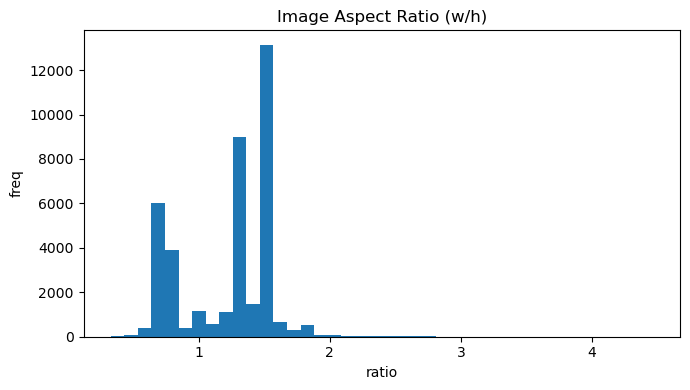

In [33]:
def size_stats(path):
    with Image.open(path) as im:
        im = ImageOps.exif_transpose(im)
        w,h = im.size
        return w,h, (w/h if h else np.nan)

rows = []
for _,r in df.iterrows():
    try:
        w,h,ar = size_stats(r["image_path"])
        rows.append({"Label": r["Label"], "w": w, "h": h, "aspect": ar})
    except Exception:
        pass
img_stats = pd.DataFrame(rows)
print("\nImage size/ratio describe:")
print(img_stats[["w","h","aspect"]].describe().round(2).to_string())

plt.figure(figsize=(7,4)); plt.hist(img_stats["aspect"].dropna(), bins=40)
plt.title("Image Aspect Ratio (w/h)"); plt.xlabel("ratio"); plt.ylabel("freq")
plt.tight_layout(); plt.show()


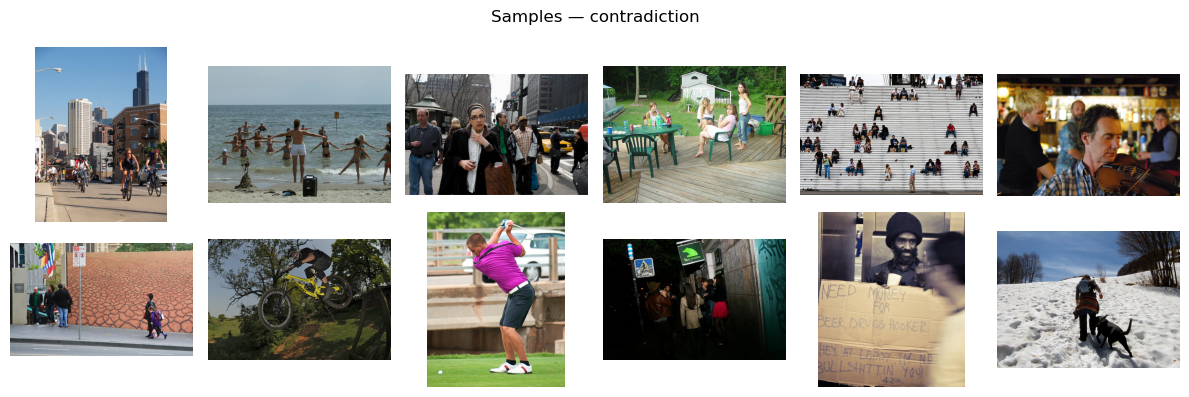

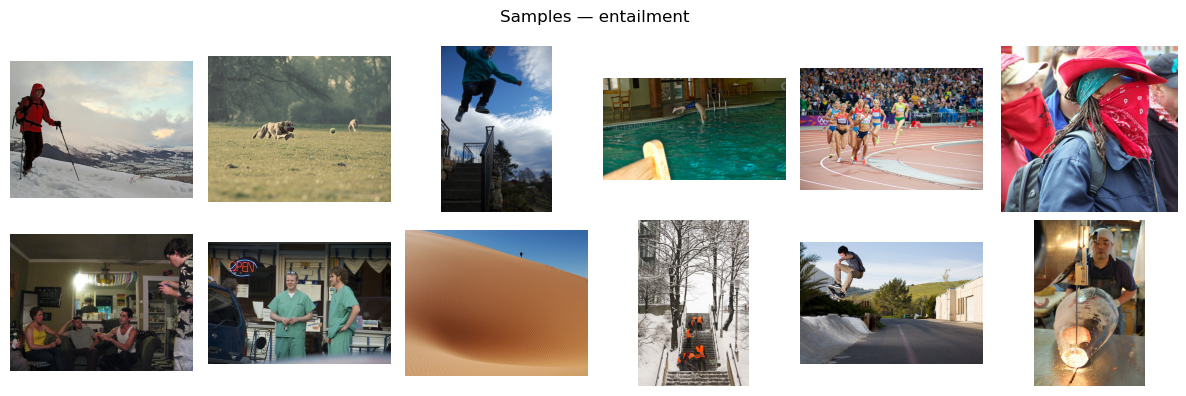

In [34]:
def montage(paths, n=12, cols=6, title="Montage"):
    paths = paths[:n]
    rows = math.ceil(len(paths)/cols) if cols else 1
    plt.figure(figsize=(cols*2, rows*2))
    for i,p in enumerate(paths):
        try:
            img = Image.open(p).convert("RGB")
            plt.subplot(rows, cols, i+1)
            plt.imshow(img); plt.axis("off")
        except: pass
    plt.suptitle(title); plt.tight_layout(); plt.show()

for lbl in label_names:
    subset = df[df["Label"]==lbl]["image_path"].sample(
        min(12, sum(df["Label"]==lbl)), random_state=SEED).tolist()
    if subset:
        montage(subset, n=len(subset), cols=6, title=f"Samples — {lbl}")


In [35]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import hashlib

# ---------- 1️⃣ Hashing helper (MD5) ----------
def md5_file(path, chunk_size=8192):
    try:
        h = hashlib.md5()
        with open(path, "rb") as f:
            while chunk := f.read(chunk_size):
                h.update(chunk)
        return h.hexdigest()
    except Exception:
        return None

# ---------- 2️⃣ Attach image_md5 if missing ----------
if "image_md5" not in df.columns:
    tqdm.pandas(desc="Hashing images")
    df["image_md5"] = df["image_path"].astype(str).progress_apply(md5_file)

# ---------- 3️⃣ Keep only unique images by hash ----------
df_unique = df.drop_duplicates(subset=["image_md5"], keep="first").dropna(subset=["image_md5"]).reset_index(drop=True)
print(f"🧩 {len(df_unique)} unique images (from {len(df)} total rows)")

# ---------- 4️⃣ Helper: load + histogram ----------
def load_image(path, color_mode="rgb"):
    img = cv2.imread(str(path))
    if img is None:
        return None
    if color_mode == "rgb":
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    elif color_mode == "gray":
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def compute_average_histogram(df, img_col="image_path", color_mode="rgb", bins=256):
    all_hists = []

    for path in tqdm(df[img_col], desc="Computing histograms"):
        img = load_image(path, color_mode=color_mode)
        if img is None:
            continue

        if color_mode == "gray":
            hist = cv2.calcHist([img], [0], None, [bins], [0,256]).flatten()
        else:
            hist_r = cv2.calcHist([img], [0], None, [bins], [0,256]).flatten()
            hist_g = cv2.calcHist([img], [1], None, [bins], [0,256]).flatten()
            hist_b = cv2.calcHist([img], [2], None, [bins], [0,256]).flatten()
            hist = np.stack([hist_r, hist_g, hist_b], axis=1)

        # Normalize per image
        hist = hist / (hist.sum() + 1e-8)
        all_hists.append(hist)

    avg_hist = np.mean(np.stack(all_hists, axis=0), axis=0)
    return avg_hist

# ---------- 5️⃣ Plot ----------
def plot_average_histogram(avg_hist, color_mode="rgb"):
    bins = np.arange(len(avg_hist))
    plt.figure(figsize=(8,4))
    if color_mode == "gray":
        plt.plot(bins, avg_hist, color="black")
        plt.title("Average Grayscale Histogram (Unique Images)")
        plt.xlabel("Pixel intensity (0–255)")
        plt.ylabel("Normalized frequency")
    else:
        plt.plot(bins, avg_hist[:,0], color="r", label="Red")
        plt.plot(bins, avg_hist[:,1], color="g", label="Green")
        plt.plot(bins, avg_hist[:,2], color="b", label="Blue")
        plt.title("Average RGB Histogram (Unique Images)")
        plt.xlabel("Pixel intensity (0–255)")
        plt.ylabel("Normalized frequency")
        plt.legend()
    plt.tight_layout()
    plt.show()

# ---------- 6️⃣ Run ----------
# avg_hist = compute_average_histogram(df_unique, img_col="image_path", color_mode="rgb", bins=256)
# plot_average_histogram(avg_hist, color_mode="rgb")


🧩 19573 unique images (from 39129 total rows)


### USE & CLIP similarities

In [36]:
import pandas as pd
import numpy as np

# --- 0) sanity: required columns present?
req = {"Image_ID", "Label", "Hypothesis", "Premise", "image_path"}
missing = req - set(df.columns)
if missing:
    raise ValueError(f"df is missing columns: {sorted(missing)}")

# --- 1) normalize Label text a bit for consistency
def norm_label(x):
    if pd.isna(x):
        return x
    return str(x).strip()

df = df.copy()
df["Label"] = df["Label"].map(norm_label)

# --- 2) define unique_labels automatically (sorted for stable id order)
unique_labels = sorted(df["Label"].dropna().unique().tolist())

# --- 3) create mappings
label2id = {lbl: i for i, lbl in enumerate(unique_labels)}
id2label = {i: lbl for lbl, i in label2id.items()}

# --- 4) attach label_id
df["label_id"] = df["Label"].map(label2id).astype("Int64")  # stays NA if Label missing

# --- 5) keep only requested columns in preferred order
df_trained = df[["Image_ID", "Label", "Hypothesis", "Premise", "image_path", "label_id"]].copy()

# --- 6) inspect / export
print("✅ Label → id mapping:", label2id)
print("🧠 Unique labels:", unique_labels)


✅ Label → id mapping: {'contradiction': 0, 'entailment': 1}
🧠 Unique labels: ['contradiction', 'entailment']


In [37]:
print(df_trained)

         Image_ID          Label  \
0      4564320256     entailment   
1      4564320256  contradiction   
2      4564320256  contradiction   
3      3945005060  contradiction   
4       369186134     entailment   
...           ...            ...   
39124  3470718914  contradiction   
39125  2867460039  contradiction   
39126   488089932     entailment   
39127   488089932  contradiction   
39128  4859164621  contradiction   

                                             Hypothesis  \
0                   The old woman and a girl are bored.   
1              Two old men robbing a convenience store.   
2                 A man implies that he is very strong.   
3       People rubbing sticks to start a fire in a pit.   
4                              Dogs are out in the snow   
...                                                 ...   
39124                 the passenger is at home sleeping   
39125                A band performs for nobody at all.   
39126  A boy is hula hooping while a

## Data cleaning and split

In [38]:
import pandas as pd

def clean_label(df: pd.DataFrame) -> pd.DataFrame:
    """
    Clean and deduplicate a label map DataFrame.
    Removes NaNs, trims whitespace, drops duplicates, 
    and keeps only the required columns in order.
    
    Expected columns:
        ["Image_ID", "Label", "Hypothesis", "Premise", "image_path", "label_id"]
    """
    df = df.copy()

    # --- 1. Ensure required columns exist
    required = ["Image_ID", "Label", "Hypothesis", "Premise", "image_path", "label_id"]
    missing = set(required) - set(df.columns)
    if missing:
        raise ValueError(f"Missing columns: {sorted(missing)}")

    # --- 2. Drop rows with NaN in key columns
    df = df.dropna(subset=["Image_ID", "Label", "Hypothesis", "Premise", "image_path"])

    # --- 3. Convert to string and strip whitespace
    for col in ["Image_ID", "Label", "Hypothesis", "Premise", "image_path"]:
        df[col] = df[col].astype(str).str.strip()

    # --- 4. Remove duplicate rows (exact same Image_ID, Hypothesis, Premise)
    df = df.drop_duplicates(subset=["Image_ID", "Hypothesis", "Premise"], keep="first")

    # --- 5. Normalize label text (optional: lowercase)
    df["Label"] = df["Label"].str.lower()

    # --- 6. Reorder columns
    df = df[required]

    # --- 7. Reset index
    df = df.reset_index(drop=True)

    print(f"✅ Cleaned: {len(df)} rows, {df['Image_ID'].nunique()} unique images")
    return df


In [39]:
clean_df = clean_label(df_trained)

✅ Cleaned: 39128 rows, 19573 unique images


In [40]:
clean_df.head()

,Image_ID,Label,Hypothesis,Premise,image_path,label_id
0,4564320256,entailment,The old woman and a girl are bored.,An old woman and a young girl are sitting arou...,./A2_Data/A2_Images/4564320256.jpg,1
1,4564320256,contradiction,Two old men robbing a convenience store.,An old lady and her granddaughter working in a...,./A2_Data/A2_Images/4564320256.jpg,0
2,4564320256,contradiction,A man implies that he is very strong.,Two women sitting down reading newspapers.,./A2_Data/A2_Images/4564320256.jpg,0
3,3945005060,contradiction,People rubbing sticks to start a fire in a pit.,Three people at a library with computers.,./A2_Data/A2_Images/3945005060.jpg,0
4,369186134,entailment,Dogs are out in the snow,Three dogs next to a blue fence in the snow.,./A2_Data/A2_Images/369186134.jpg,1


array([[<Axes: title={'center': 'label_id'}>]], dtype=object)

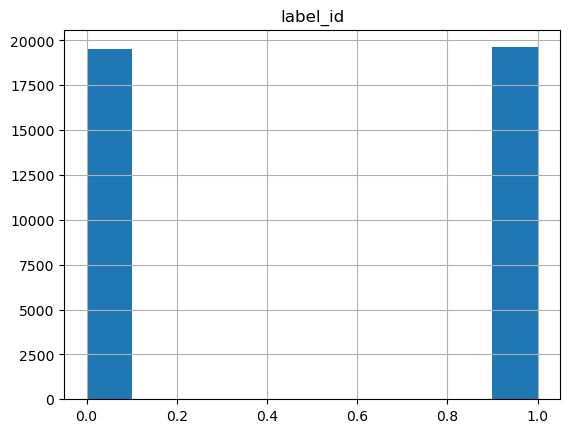

In [41]:
clean_df.hist()

In [42]:
from sklearn.model_selection import GroupShuffleSplit
import pandas as pd

def grouped_split(
    df: pd.DataFrame,
    group_col: str = "Image_ID",
    train_size: float = 0.7,
    val_size: float = 0.15,
    test_size: float = 0.15,
    random_state: int = 42,
):
    """
    Split DataFrame into train/val/test using GroupShuffleSplit,
    keeping all rows of each group (e.g. Image_ID) in the same split.

    Args:
        df (pd.DataFrame): cleaned dataset
        group_col (str): grouping column, e.g. 'Image_ID'
        train_size (float): fraction of groups for training
        val_size (float): fraction of groups for validation
        test_size (float): fraction of groups for test
        random_state (int): reproducibility seed

    Returns:
        (train_df, val_df, test_df)
    """
    total = train_size + val_size + test_size
    if not abs(total - 1.0) < 1e-6:
        raise ValueError(f"train+val+test must sum to 1. Got {total:.2f}")

    groups = df[group_col].values

    # 🟩 Split 1: Train vs (Val+Test)
    gss1 = GroupShuffleSplit(n_splits=1, train_size=train_size, random_state=random_state)
    train_idx, temp_idx = next(gss1.split(df, groups=groups))
    train_df = df.iloc[train_idx].reset_index(drop=True)
    temp_df  = df.iloc[temp_idx].reset_index(drop=True)

    # 🟨 Split 2: Val vs Test (split temp 50:50 because val=test=15%)
    gss2 = GroupShuffleSplit(n_splits=1, train_size=0.5, random_state=random_state)
    val_idx, test_idx = next(gss2.split(temp_df, groups=temp_df[group_col].values))
    val_df  = temp_df.iloc[val_idx].reset_index(drop=True)
    test_df = temp_df.iloc[test_idx].reset_index(drop=True)

    # 🧾 Summary
    print(f"✅ Split complete ({len(df):,} rows total)")
    print(f"  Train: {len(train_df):,} rows | {train_df[group_col].nunique():,} unique {group_col}s")
    print(f"  Val:   {len(val_df):,} rows | {val_df[group_col].nunique():,} unique {group_col}s")
    print(f"  Test:  {len(test_df):,} rows | {test_df[group_col].nunique():,} unique {group_col}s")

    return train_df, val_df, test_df


In [43]:
df.info

<bound method DataFrame.info of          Image_ID          Label  \
0      4564320256     entailment   
1      4564320256  contradiction   
2      4564320256  contradiction   
3      3945005060  contradiction   
4       369186134     entailment   
...           ...            ...   
39124  3470718914  contradiction   
39125  2867460039  contradiction   
39126   488089932     entailment   
39127   488089932  contradiction   
39128  4859164621  contradiction   

                                             Hypothesis  \
0                   The old woman and a girl are bored.   
1              Two old men robbing a convenience store.   
2                 A man implies that he is very strong.   
3       People rubbing sticks to start a fire in a pit.   
4                              Dogs are out in the snow   
...                                                 ...   
39124                 the passenger is at home sleeping   
39125                A band performs for nobody at all.   
3912

In [44]:
train_df, val_df, test_df = grouped_split(clean_df, group_col="Image_ID", random_state=42)

✅ Split complete (39,128 rows total)
  Train: 27,507 rows | 13,701 unique Image_IDs
  Val:   5,801 rows | 2,936 unique Image_IDs
  Test:  5,820 rows | 2,936 unique Image_IDs


In [45]:
train_df.columns

Index(['Image_ID', 'Label', 'Hypothesis', 'Premise', 'image_path', 'label_id'], dtype='object')

array([[<Axes: title={'center': 'label_id'}>]], dtype=object)

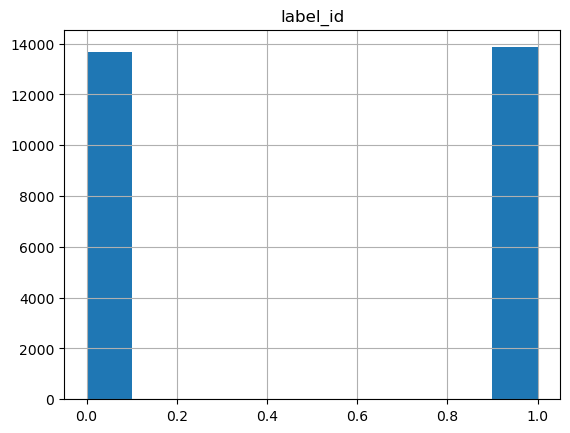

In [46]:
train_df.hist()

array([[<Axes: title={'center': 'label_id'}>]], dtype=object)

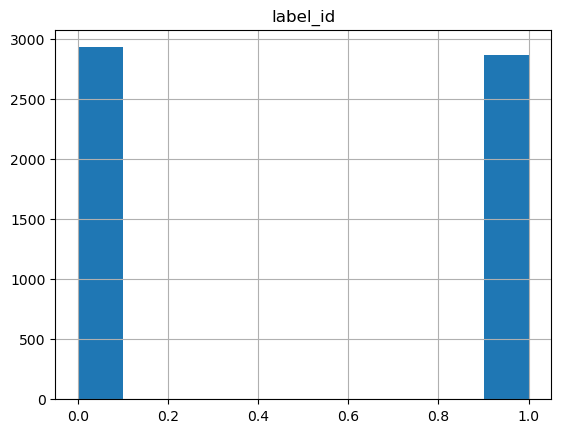

In [47]:
val_df.hist()

array([[<Axes: title={'center': 'label_id'}>]], dtype=object)

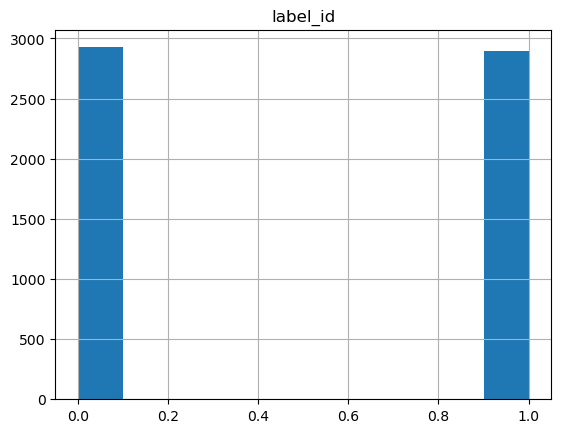

In [48]:
test_df.hist()

## Image augmenation 

In [49]:
# !pip install -U keras-cv keras-nlp tfclip ftfy

## Evaluation frame work (goal:...)

In [50]:
train_df.head()

,Image_ID,Label,Hypothesis,Premise,image_path,label_id
0,4564320256,entailment,The old woman and a girl are bored.,An old woman and a young girl are sitting arou...,./A2_Data/A2_Images/4564320256.jpg,1
1,4564320256,contradiction,Two old men robbing a convenience store.,An old lady and her granddaughter working in a...,./A2_Data/A2_Images/4564320256.jpg,0
2,4564320256,contradiction,A man implies that he is very strong.,Two women sitting down reading newspapers.,./A2_Data/A2_Images/4564320256.jpg,0
3,3945005060,contradiction,People rubbing sticks to start a fire in a pit.,Three people at a library with computers.,./A2_Data/A2_Images/3945005060.jpg,0
4,369186134,entailment,Dogs are out in the snow,Three dogs next to a blue fence in the snow.,./A2_Data/A2_Images/369186134.jpg,1


In [51]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [52]:
import os, json, hashlib, random, math, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

import seaborn as sns
from PIL import Image
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

try:
    from tfclip import create_model_and_transforms
    TFCLIP_AVAILABLE = True
except Exception:
    print("⚠️ Install tfclip with: pip install tfclip")
    TFCLIP_AVAILABLE = False

SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)
print("TF:", tf.__version__)

TF: 2.19.1


In [53]:
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")
print(f"Built with CUDA: {tf.test.is_built_with_cuda()}")

TensorFlow version: 2.19.1
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Built with CUDA: True


In [54]:

IMAGE_SIZE    = (224,224)
BATCH_SIZE    = 32
EPOCHS_STAGE1 = 5
EPOCHS_STAGE2 = 10
LR_STAGE1     = 1e-3
LR_STAGE2     = 1e-5


## Data Prprofessosr

In [55]:
train_df.columns

Index(['Image_ID', 'Label', 'Hypothesis', 'Premise', 'image_path', 'label_id'], dtype='object')

In [56]:
print("🔍 LABEL ANALYSIS")
print("="*40)
print(f"Unique labels in train_df: {sorted(train_df['label_id'].unique())}")
print(f"Label counts: {train_df['label_id'].value_counts().sort_index()}")
print(f"Expected NUM_CLASSES: {len(train_df['label_id'].unique())}")

🔍 LABEL ANALYSIS
Unique labels in train_df: [np.int64(0), np.int64(1)]
Label counts: label_id
0    13651
1    13856
Name: count, dtype: Int64
Expected NUM_CLASSES: 2


In [57]:
pd

<module 'pandas' from '/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/pandas/__init__.py'>

In [58]:
BATCH_SIZE = 32

In [59]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, metrics
import matplotlib.pyplot as plt
import seaborn as sns

import albumentations as A
import cv2
import ftfy
from tfclip import create_model_and_transforms
from tqdm import tqdm

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [60]:
# Using tfclip instead of KerasHub presets
print("Using tfclip. Presets are defined by model/pretrained names in tfclip.")
print("Examples:")
print("  - MODEL_NAME='ViT-B-32-quickgelu', PRETRAINED='openai'")
print("  - MODEL_NAME='ViT-B-32', PRETRAINED='laion400m_e31'")
import os
# Force CPU to avoid CuDNN mismatch during sanity check
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np, keras
from tfclip import create_model_and_transforms

MODEL_NAME = "ViT-B-32-quickgelu"
PRETRAINED = "openai"
_, image_prep, text_prep = create_model_and_transforms(MODEL_NAME, pretrained=PRETRAINED)

Using tfclip. Presets are defined by model/pretrained names in tfclip.
Examples:
  - MODEL_NAME='ViT-B-32-quickgelu', PRETRAINED='openai'
  - MODEL_NAME='ViT-B-32', PRETRAINED='laion400m_e31'


In [61]:
TEXT_MODE = "hypothesis+premise"  # "hypothesis" or "hypothesis+premise"

# Training config (from your existing setup)
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS_STAGE1 = 5
EPOCHS_STAGE2 = 10
LR_STAGE1 = 1e-3
LR_STAGE2 = 1e-5

NUM_CLASSES = len(train_df['label_id'].unique())

print(f"✅ Configuration:")
print(f"   NUM_CLASSES: {NUM_CLASSES}")
print(f"   TEXT_MODE: {TEXT_MODE}")

✅ Configuration:
   NUM_CLASSES: 2
   TEXT_MODE: hypothesis+premise


In [62]:
# !pip install --upgrade tfclip

In [63]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import albumentations as A
from typing import Dict, Tuple, Generator

# ============================================================================
# DATA GENERATOR (same as yours)
# ============================================================================

class CLIPDataGenerator:
    """Generator for CLIP model inputs with image augmentation."""
    
    def __init__(
        self,
        df: pd.DataFrame,
        text_preprocessor,
        image_size: Tuple[int, int] = (224, 224),
        max_text_length: int = 77,
        augment: bool = False,
        shuffle: bool = True,
        seed: int = 42
    ):
        self.df = df.copy().reset_index(drop=True)
        self.text_preprocessor = text_preprocessor
        self.image_size = image_size
        self.max_text_length = max_text_length
        self.augment = augment
        self.shuffle = shuffle
        self.seed = seed
        self.indices = np.arange(len(self.df))
        
        # Setup augmentations
        if self.augment:
            self.transform = A.Compose([
                A.SmallestMaxSize(max(image_size)),
                A.RandomCrop(height=image_size[0], width=image_size[1]),
                A.HorizontalFlip(p=0.5),
                A.RandomBrightnessContrast(
                    brightness_limit=0.2, 
                    contrast_limit=0.2, 
                    p=0.5
                ),
                A.HueSaturationValue(
                    hue_shift_limit=10, 
                    sat_shift_limit=20, 
                    val_shift_limit=10, 
                    p=0.3
                ),
                A.OneOf([
                    A.GaussNoise(var_limit=(5, 15), p=1),
                    A.GaussianBlur(blur_limit=(3, 5), p=1),
                ], p=0.2),
            ])
        else:
            self.transform = A.Compose([
                A.SmallestMaxSize(max(image_size)),
                A.CenterCrop(height=image_size[0], width=image_size[1]),
            ])
    
    def _load_and_preprocess_image(self, image_path: str) -> np.ndarray:
        """Load and preprocess a single image."""
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if img is None:
            raise ValueError(f"Failed to load image: {image_path}")
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self.transform(image=img)['image']
        img = img.astype(np.float32) / 255.0
        
        return img
    
    def _tokenize_text(self, premise: str, hypothesis: str) -> np.ndarray:
        """Tokenize text pair using CLIP tokenizer."""
        combined_text = f"{premise} [SEP] {hypothesis}"
        tokens = self.text_preprocessor([combined_text])
        
        if isinstance(tokens, dict):
            token_ids = next(iter(tokens.values()))
        else:
            token_ids = tokens
        
        if isinstance(token_ids, (list, tuple)):
            token_ids = token_ids[0]
        
        token_ids = np.array(token_ids, dtype=np.int32)
        
        if token_ids.ndim == 2:
            token_ids = token_ids[0]
        
        if len(token_ids) > self.max_text_length:
            token_ids = token_ids[:self.max_text_length]
        elif len(token_ids) < self.max_text_length:
            token_ids = np.pad(
                token_ids, 
                (0, self.max_text_length - len(token_ids)),
                constant_values=0
            )
        
        return token_ids.astype(np.int32)
    
    def __call__(self) -> Generator:
        """Generator function for tf.data.Dataset."""
        # Shuffle indices at start of each epoch
        if self.shuffle:
            np.random.RandomState(self.seed).shuffle(self.indices)
        
        for idx in self.indices:
            row = self.df.iloc[idx]
            
            try:
                image = self._load_and_preprocess_image(row['image_path'])
                tokens = self._tokenize_text(row['Premise'], row['Hypothesis'])
                label = np.int32(row['label_id'])
                
                yield (
                    {
                        'vision_images': image,
                        'text_texts': tokens
                    },
                    label
                )
                
            except Exception as e:
                print(f"Warning: Failed to process row {idx}: {e}")
                continue
    
    def __len__(self):
        return len(self.df)


# ============================================================================
# FIXED DATASET BUILDER WITH .repeat()
# ============================================================================

def create_dataset_from_generator(
    df: pd.DataFrame,
    text_preprocessor,
    image_size: Tuple[int, int] = (224, 224),
    batch_size: int = 32,
    max_text_length: int = 77,
    augment: bool = False,
    shuffle: bool = True,
    drop_remainder: bool = True,
    repeat: bool = False,  # ✅ NEW PARAMETER!
    seed: int = 42
) -> tf.data.Dataset:
    """
    Create a tf.data.Dataset from a DataFrame using a generator.
    
    Args:
        df: DataFrame with columns ['image_path', 'Premise', 'Hypothesis', 'label_id']
        text_preprocessor: CLIP text preprocessor
        image_size: Target image size (H, W)
        batch_size: Batch size
        max_text_length: Maximum text token length
        augment: Whether to apply data augmentation
        shuffle: Whether to shuffle data
        drop_remainder: Whether to drop last incomplete batch
        repeat: Whether to repeat dataset infinitely (True for training)
        seed: Random seed
    
    Returns:
        tf.data.Dataset yielding (inputs_dict, labels)
    """
    # Create generator
    generator = CLIPDataGenerator(
        df=df,
        text_preprocessor=text_preprocessor,
        image_size=image_size,
        max_text_length=max_text_length,
        augment=augment,
        shuffle=shuffle,
        seed=seed
    )
    
    # Define output signature
    output_signature = (
        {
            'vision_images': tf.TensorSpec(
                shape=(*image_size, 3), 
                dtype=tf.float32
            ),
            'text_texts': tf.TensorSpec(
                shape=(max_text_length,), 
                dtype=tf.int32
            )
        },
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
    
    # Create dataset from generator
    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=output_signature
    )
    
    # ✅ ADD .repeat() for training
    if repeat:
        dataset = dataset.repeat()  # Infinite dataset
    
    # Batch and prefetch
    dataset = dataset.batch(batch_size, drop_remainder=drop_remainder)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset



In [64]:

# Configuration
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
MAX_TEXT_LENGTH = 77
SEED = 42

print("Creating training dataset...")
train_dataset = create_dataset_from_generator(
    df=train_df,
    text_preprocessor=text_prep,  # from tfclip
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    max_text_length=MAX_TEXT_LENGTH,
    augment=True,      # Enable augmentation for training
    shuffle=True,      # Shuffle training data
    drop_remainder=True,
    seed=SEED 
)

print("Creating validation dataset...")
val_dataset = create_dataset_from_generator(
    df=val_df,
    text_preprocessor=text_prep,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    max_text_length=MAX_TEXT_LENGTH,
    augment=False,     # No augmentation for validation
    shuffle=False,     # No shuffle for validation
    drop_remainder=False,
    repeat=True, 
    seed=SEED 
)

# Verify dataset
print("\n" + "="*60)
print("DATASET VERIFICATION")
print("="*60)

for inputs, labels in train_dataset.take(1):
    print(f"Batch structure:")
    print(f"  Images shape: {inputs['vision_images'].shape}")
    print(f"  Tokens shape: {inputs['text_texts'].shape}")
    print(f"  Labels shape: {labels.shape}")
    print(f"\nData types:")
    print(f"  Images dtype: {inputs['vision_images'].dtype}")
    print(f"  Tokens dtype: {inputs['text_texts'].dtype}")
    print(f"  Labels dtype: {labels.dtype}")
    print(f"\nValue ranges:")
    print(f"  Images: [{inputs['vision_images'].numpy().min():.3f}, {inputs['vision_images'].numpy().max():.3f}]")
    print(f"  Tokens: [{inputs['text_texts'].numpy().min()}, {inputs['text_texts'].numpy().max()}]")
    print(f"  Labels: {np.unique(labels.numpy())}")

print("="*60)


Creating training dataset...
Creating validation dataset...

DATASET VERIFICATION


/tmp/ipykernel_22896/2258737940.py:54: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5, 15), p=1),
2025-10-10 00:35:14.329225: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT64 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


Batch structure:
  Images shape: (32, 224, 224, 3)
  Tokens shape: (32, 77)
  Labels shape: (32,)

Data types:
  Images dtype: <dtype: 'float32'>
  Tokens dtype: <dtype: 'int32'>
  Labels dtype: <dtype: 'int32'>

Value ranges:
  Images: [0.000, 1.000]
  Tokens: [0, 49407]
  Labels: [0 1]


2025-10-10 00:35:35.399689: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [65]:
from keras import Model, layers
import tensorflow as tf

class CLIPEntailmentModel(Model):
    """CLIP entailment model with explicit shape handling for XLA compatibility."""

    def __init__(self, clip_backbone, num_classes=3, dropout_rate = 0.1, **kwargs):
        # super().__init__(**kwargs)
        self.num_classes = num_classes
        
        # Get normalized outputs BEFORE pooling
        vision_norm = clip_backbone.get_layer('vision_head_norm').output  # (B, 50, 768)
        text_norm = clip_backbone.get_layer('text_head_norm').output      # (B, 77, 512)
        
        print(f"Vision norm output: {vision_norm.shape}")
        print(f"Text norm output: {text_norm.shape}")
        
        # Vision: extract CLS token (index 0)
        vision_pooled = layers.Lambda(
            lambda x: x[:, 0, :], 
            name='vision_cls'
        )(vision_norm)
        
        # Text: mean pooling with explicit reduction
        text_pooled = layers.Lambda(
            lambda x: tf.reduce_mean(x, axis=1),  # Explicit mean over sequence
            name='text_mean'
        )(text_norm)
        
        print(f"Vision pooled: {vision_pooled.shape}")
        print(f"Text pooled: {text_pooled.shape}")
        
        # Project to 512 dims
        vision_proj = layers.Dense(512, use_bias=False, name='vision_proj')(vision_pooled)
        text_proj = layers.Dense(512, use_bias=False, name='text_proj')(text_pooled)
        
        # L2 normalize with epsilon for stability
        vision_norm_out = layers.Lambda(
            lambda x: tf.nn.l2_normalize(x, axis=-1, epsilon=1e-12),
            name='vision_l2'
        )(vision_proj)
        
        text_norm_out = layers.Lambda(
            lambda x: tf.nn.l2_normalize(x, axis=-1, epsilon=1e-12),
            name='text_l2'
        )(text_proj)
        
        # Concatenate - both should be (B, 512)
        combined = layers.Concatenate(axis=-1, name='entail_concat')([vision_norm_out, text_norm_out])
        
        # Classification head
        x = layers.Dense(512, activation='relu', name='entail_dense1')(combined)
        x = layers.Dropout(dropout_rate, name='entail_dropout')(x)
        outputs = layers.Dense(num_classes, activation='softmax', name='entail_classifier')(x)
        
        # Build model
        super().__init__(
            inputs=clip_backbone.inputs,
            outputs=outputs,
            name='clip_entailment_model'
        )
        
        # Freeze contrastive head
        for layer in self.layers:
            if 'head_sim' in layer.name or 'head_prob' in layer.name:
                layer.trainable = False
        
        print(f"\n✓ Model created: Combined (B, 1024) → Output (B, {num_classes})")

def create_fresh_model(num_classes, dropout_rate=0.1):
    """Create a new model instance for each trial."""
    # Clear session
    tf.keras.backend.clear_session()
    
    # Recreate backbone
    backbone, _, _ = create_model_and_transforms(
        MODEL_NAME, 
        pretrained=PRETRAINED
    )
    
    # Build entailment model
    model = CLIPEntailmentModel(
        clip_backbone=backbone,
        num_classes=num_classes,
        dropout_rate = dropout_rate
    )
    
    return model


print('Creating CLIP entailment model...')
model = create_fresh_model(2,0.1)
print(f'Classes: {list(label2id.keys())}')

# Sanity test on a single batch if available
try:
    sample = next(iter(train_dataset.take(1)))
    inputs, labels = sample
    out = model(inputs, training=False)
    print('Sanity output shape:', out.shape)
except Exception as e:
    print('Sanity test skipped/failed:', e)

Creating CLIP entailment model...
Vision norm output: (None, 50, 768)
Text norm output: (None, None, 512)
Vision pooled: (None, 768)
Text pooled: (None, 512)

✓ Model created: Combined (B, 1024) → Output (B, 2)
Classes: ['contradiction', 'entailment']


I0000 00:00:1760056545.310683   22896 cuda_dnn.cc:529] Loaded cuDNN version 90300


Sanity output shape: (32, 2)


## Modeling

In [66]:
# Custom F1 Score Metric
class F1Score(tf.keras.metrics.Metric):
    """F1 Score metric for multi-class classification."""
    
    def __init__(self, num_classes, average='macro', name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.average = average
        
        # Initialize confusion matrix variables
        self.true_positives = self.add_weight(
            name='tp', shape=(num_classes,), initializer='zeros'
        )
        self.false_positives = self.add_weight(
            name='fp', shape=(num_classes,), initializer='zeros'
        )
        self.false_negatives = self.add_weight(
            name='fn', shape=(num_classes,), initializer='zeros'
        )
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.argmax(y_pred, axis=-1)
        y_true = tf.cast(tf.squeeze(y_true), tf.int64)
        y_pred = tf.cast(y_pred, tf.int64)
        
        # Calculate confusion matrix for each class
        for class_id in range(self.num_classes):
            # True positives
            tp = tf.reduce_sum(
                tf.cast((y_true == class_id) & (y_pred == class_id), tf.float32)
            )
            # False positives
            fp = tf.reduce_sum(
                tf.cast((y_true != class_id) & (y_pred == class_id), tf.float32)
            )
            # False negatives
            fn = tf.reduce_sum(
                tf.cast((y_true == class_id) & (y_pred != class_id), tf.float32)
            )
            
            self.true_positives[class_id].assign_add(tp)
            self.false_positives[class_id].assign_add(fp)
            self.false_negatives[class_id].assign_add(fn)
    
    def result(self):
        # Calculate precision and recall for each class
        precision = self.true_positives / (
            self.true_positives + self.false_positives + K.epsilon()
        )
        recall = self.true_positives / (
            self.true_positives + self.false_negatives + K.epsilon()
        )
        
        # Calculate F1 score for each class
        f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
        
        # Return average based on strategy
        if self.average == 'macro':
            return tf.reduce_mean(f1)
        elif self.average == 'micro':
            # Micro average
            total_tp = tf.reduce_sum(self.true_positives)
            total_fp = tf.reduce_sum(self.false_positives)
            total_fn = tf.reduce_sum(self.false_negatives)
            
            micro_precision = total_tp / (total_tp + total_fp + K.epsilon())
            micro_recall = total_tp / (total_tp + total_fn + K.epsilon())
            
            return 2 * (micro_precision * micro_recall) / (
                micro_precision + micro_recall + K.epsilon()
            )
        else:
            return tf.reduce_mean(f1)
    
    def reset_state(self):
        self.true_positives.assign(tf.zeros_like(self.true_positives))
        self.false_positives.assign(tf.zeros_like(self.false_positives))
        self.false_negatives.assign(tf.zeros_like(self.false_negatives))

In [67]:
# import tensorflow as tf
from tensorflow import keras

# One-stage training scaffold for Optuna later
# Expects train_ds and val_ds as tf.data.Dataset yielding (inputs, labels)
# Inputs must match the model signature: for tfclip typically {"vision_images": ..., "text_texts": ...}
import math
import tensorflow as tf
from focal_loss import SparseCategoricalFocalLoss  # pip install focal-loss
# Unfreeze a percentage of layers (by trainable weights presence order)
def unfreeze_percentage(model: tf.keras.Model, percent: float) -> None:
    """Unfreezes the last `percent` of layers that have trainable weights.
    percent in [0,1]. 0 -> freeze all; 1 -> unfreeze all.
    """
    percent = float(max(0.0, min(1.0, percent)))
    # Gather layers that have trainable variables
    layers_with_weights = [l for l in model.layers if l.trainable_weights]
    if not layers_with_weights:
        # Fallback: consider all layers
        layers_with_weights = list(model.layers)
    k = max(0, math.floor(len(layers_with_weights) * percent))
    cutoff = len(layers_with_weights) - k
    for idx, layer in enumerate(layers_with_weights):
        layer.trainable = idx >= cutoff
    # Ensure BN-like layers remain in inference mode if desired (optional)
    # for l in model.layers:
    #     if isinstance(l, (tf.keras.layers.BatchNormalization,)):
    #         l.trainable = False

print("unfreeze_percentage ready.")
def run_one_stage_training(model, train_ds, val_ds, percent_unfreeze=0.2, lr=1e-4, epochs=1, 
                           gamma= 0.1, class_weight= [0.2,0.2]):
    # Unfreeze a portion of the model
    unfreeze_percentage(model, percent_unfreeze)

    # Compile
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    loss = SparseCategoricalFocalLoss(
            gamma=gamma,
            class_weight=class_weight,  # Can also use array for per-class weights
            from_logits=False # Set True if model outputs logits
        )
    metrics = [keras.metrics.SparseCategoricalAccuracy(name="acc")]
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    steps_per_epoch    = len(train_df) // BATCH_SIZE
    validation_steps   = len(val_df)   // BATCH_SIZE
    # Train
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        verbose=1,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
    )
    return history

print("run_one_stage_training ready. Provide train_ds/val_ds to use it.")

unfreeze_percentage ready.
run_one_stage_training ready. Provide train_ds/val_ds to use it.


In [68]:
# Create checkpoint directory
import os
os.makedirs("./checkpoints", exist_ok=True)
os.makedirs("./logs", exist_ok=True)

# Train the model
print("Starting CLIP fine-tuning...")
history = run_one_stage_training(
    model=model,
    train_ds=train_dataset,
    val_ds=val_dataset,
    percent_unfreeze=0.2,      # Unfreeze last 20% of layers
    lr=1e-4,
    epochs=5,
    # steps_per_epoch=steps_per_epoch,
    # validation_steps=validation_steps,
    # from_logits=False,         # Your model uses softmax
    # verbose=1
)

print("Training completed!")

# Save the final model
model.save("./models/clip_entailment_final.keras")
print("Model saved to ./models/clip_entailment_final.keras")

Starting CLIP fine-tuning...
Epoch 1/5


I0000 00:00:1760056566.526302   23061 service.cc:152] XLA service 0x7fdf50041740 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760056566.526326   23061 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-10-10 00:36:07.669651: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-10 00:36:20.045540: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_13', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_2', 4 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_14', 4 bytes spill stores, 4 bytes spill loads
ptxas warnin

 55/859 ━━━━━━━━━━━━━━━━━━━━ 13:41 1s/step - acc: 0.5270 - loss: 0.1286


KeyboardInterrupt



### Model Evaluation

In [ ]:
# Plot training history
def plot_training_history(history):
    """Plot training and validation metrics."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Loss
    axes[0].plot(history.history['loss'], label='Train Loss')
    axes[0].plot(history.history['val_loss'], label='Val Loss')
    axes[0].set_title('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # Accuracy
    axes[1].plot(history.history['acc'], label='Train Accuracy')
    axes[1].plot(history.history['val_acc'], label='Val Accuracy')
    axes[1].set_title('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm.auto import tqdm
from typing import Dict, Optional, Union
import os

def predict_large_dataset(
    model: tf.keras.Model,
    df: pd.DataFrame,
    text_preprocessor,
    image_size: tuple = (224, 224),
    batch_size: int = 32,
    max_text_length: int = 77,
    return_probabilities: bool = True,
    verbose: bool = True,
    save_path: Optional[str] = None
) -> pd.DataFrame:
    """
    Make predictions on a large dataset efficiently.
    
    Args:
        model: Trained Keras model
        df: DataFrame with columns ['image_path', 'Premise', 'Hypothesis', 'label_id']
        text_preprocessor: CLIP text preprocessor
        image_size: Image size for model input
        batch_size: Batch size for prediction
        max_text_length: Maximum text token length
        return_probabilities: Whether to return class probabilities
        verbose: Show progress bar
        save_path: Optional path to save results CSV
    
    Returns:
        DataFrame with original data + predictions
    """
    if verbose:
        print(f"🔮 Starting prediction on {len(df):,} samples...")
        print(f"   Batch size: {batch_size}")
        print(f"   Expected batches: {int(np.ceil(len(df) / batch_size))}")
    
    # Create prediction dataset (no augmentation, no shuffle)
    pred_dataset = create_dataset_from_generator(
        df=df,
        text_preprocessor=text_preprocessor,
        image_size=image_size,
        batch_size=batch_size,
        max_text_length=max_text_length,
        augment=False,  # No augmentation for prediction
        shuffle=False,  # Keep original order
        drop_remainder=False,  # Keep all samples
        seed=42
    )
    
    # Calculate number of batches
    num_batches = int(np.ceil(len(df) / batch_size))
    
    # Collect predictions
    all_predictions = []
    all_probabilities = []
    
    # Predict with progress bar
    if verbose:
        pbar = tqdm(total=num_batches, desc="Predicting", unit="batch")
    
    for batch_inputs, _ in pred_dataset.take(num_batches):
        # Get predictions for batch
        batch_probs = model.predict_on_batch(batch_inputs)
        batch_preds = np.argmax(batch_probs, axis=1)
        
        all_predictions.extend(batch_preds)
        all_probabilities.extend(batch_probs)
        
        if verbose:
            pbar.update(1)
    
    if verbose:
        pbar.close()
    
    # Convert to arrays
    all_predictions = np.array(all_predictions)
    all_probabilities = np.array(all_probabilities)
    
    # Ensure we have exactly len(df) predictions
    all_predictions = all_predictions[:len(df)]
    all_probabilities = all_probabilities[:len(df)]
    
    # Create results dataframe
    results_df = df.copy()
    results_df['predicted_label_id'] = all_predictions
    
    # Map label ids to label names
    if 'Label' in df.columns:
        id2label = {v: k for k, v in label2id.items()}
        results_df['predicted_label'] = results_df['predicted_label_id'].map(id2label)
    
    # Add probabilities if requested
    if return_probabilities:
        for i, label_name in enumerate(sorted(label2id.keys())):
            results_df[f'prob_{label_name}'] = all_probabilities[:, i]
    
    # Add confidence score (max probability)
    results_df['confidence'] = np.max(all_probabilities, axis=1)
    
    # Add correctness flag if ground truth available
    if 'label_id' in df.columns:
        results_df['is_correct'] = (
            results_df['label_id'] == results_df['predicted_label_id']
        )
        accuracy = results_df['is_correct'].mean()
        if verbose:
            print(f"\n✓ Prediction complete!")
            print(f"   Accuracy: {accuracy:.4f} ({results_df['is_correct'].sum()}/{len(df)})")
    else:
        if verbose:
            print(f"\n✓ Prediction complete!")
    
    # Save results if path provided
    if save_path:
        os.makedirs(os.path.dirname(save_path) or '.', exist_ok=True)
        results_df.to_csv(save_path, index=False)
        if verbose:
            print(f"   Results saved to: {save_path}")
    
    return results_df



In [ ]:
pred =  predict_large_dataset(
    model,
    test_df,
    text_prep)

In [ ]:
# print('Creating CLIP entailment model...')
# model = CLIPEntailmentModel(clip_backbone=backbone_model, num_classes=len(label2id))
# print(f'Classes: {list(label2id.keys())}')

# # Sanity test on a single batch if available
# try:
#     sample = next(iter(train_dataset.take(1)))
#     inputs, labels = sample
#     out = model(inputs, training=False)
#     print('Sanity output shape:', out.shape)
# except Exception as e:
#     print('Sanity test skipped/failed:', e)

In [ ]:
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
from keras import Model, layers
import tensorflow as tf
from tensorflow.keras import backend as K

def objective(trial):
    """Optuna objective function."""
    # Clear previous models
    tf.keras.backend.clear_session()
    
    # Suggest hyperparameters
    percent_unfreeze = trial.suggest_float("percent_unfreeze", 0.1, 0.5, step=0.1)
    lr = trial.suggest_float("lr", 1e-6, 1e-3, log=True)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
    
    # **Focal Loss hyperparameters**
    classweight_1 = trial.suggest_float("classweight_1", 0.1, 0.75, step=0.05)
    classweight_2 = trial.suggest_float("classweight_2", 0.1, 0.75, step=0.05)
    focal_alpha= [classweight_1, classweight_2]
    focal_gamma = trial.suggest_float("focal_gamma", 1.0, 3.0, step=0.5)
    # Create model with trial-specific dropout
    model = create_fresh_model(num_classes=len(label2id), dropout_rate=dropout_rate)
    
    try:
        # Train with suggested hyperparameters
        history = run_one_stage_training(
            model=model,
            train_ds=train_dataset,
            val_ds=val_dataset,
            percent_unfreeze=percent_unfreeze,
            lr=lr,
            epochs=10,
            gamma = focal_gamma,
            class_weight = focal_alpha
        )
        
        # Return best validation F1 score
        val_f1 = max(history.history['val_f1_score'])
        
        # Report intermediate values for pruning
        for epoch, f1 in enumerate(history.history['val_f1_score']):
            trial.report(f1, epoch)
            if trial.should_prune():
                raise optuna.TrialPruned()
        
        return val_f1
        
    except Exception as e:
        print(f"Trial failed: {e}")
        return 0.0


In [ ]:
study = optuna.create_study(
    direction="maximize",
    sampler=TPESampler(seed=42),
    pruner=MedianPruner(n_startup_trials=3, n_warmup_steps=5)
)

study.optimize(objective, n_trials=5, timeout=None)

# Print results
print("\n" + "="*50)
print("BEST TRIAL RESULTS")
print("="*50)
print(f"Best Validation F1 Score: {study.best_trial.value:.4f}")
print(f"\nBest Hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"  {key}: {value}")

# Save best hyperparameters
import json
with open('best_hyperparameters.json', 'w') as f:
    json.dump(study.best_trial.params, f, indent=4)
print("\nBest hyperparameters saved to 'best_hyperparameters.json'")

In [ ]:
# Best hyperparameters
print("\n" + "="*60)
print("BEST HYPERPARAMETERS")
print("="*60)
print(f"Best validation accuracy: {study.best_value:.4f}")
print(f"Best hyperparameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

# Visualize results
optuna.visualization.plot_optimization_history(study).show()
# optuna.visualization.plot_param_importances(study).show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import (
    roc_curve, auc, roc_auc_score,
    confusion_matrix, classification_report,
    precision_recall_curve, average_precision_score,
    cohen_kappa_score, matthews_corrcoef,
    accuracy_score, balanced_accuracy_score,
    precision_recall_fscore_support
)
from sklearn.calibration import calibration_curve
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'


# ============================================================================
# STREAMLINED MODEL ANALYZER
# ============================================================================

class ModelAnalyzer:
    """Streamlined model analysis - plots and numbers only."""
    
    def __init__(self, model, predictions_df, label2id):
        self.model = model
        self.predictions_df = predictions_df
        self.label2id = label2id
        self.id2label = {v: k for k, v in label2id.items()}
        self.class_names = sorted(label2id.keys())
        self.num_classes = len(self.class_names)
        
        self.y_true = predictions_df['label_id'].values
        self.y_pred = predictions_df['predicted_label_id'].values
        
        prob_cols = [f'prob_{label}' for label in self.class_names]
        self.y_proba = predictions_df[prob_cols].values
    
    def plot_all(self, figsize=(20, 24), save_path=None):
        """Generate all plots in one figure."""
        fig = plt.figure(figsize=figsize)
        gs = fig.add_gridspec(5, 3, hspace=0.35, wspace=0.3)
        
        # Row 1: Confusion Matrices
        self._plot_confusion_matrix(fig, gs[0, :2])
        self._plot_normalized_confusion(fig, gs[0, 2])
        
        # Row 2: ROC & PR Curves
        self._plot_roc_curves(fig, gs[1, 0])
        self._plot_roc_macro(fig, gs[1, 1])
        self._plot_pr_curves(fig, gs[1, 2])
        
        # Row 3: Calibration & Confidence
        self._plot_calibration(fig, gs[2, 0])
        self._plot_confidence_dist(fig, gs[2, 1])
        self._plot_confidence_by_class(fig, gs[2, 2])
        
        # Row 4: Per-class metrics
        self._plot_per_class_metrics(fig, gs[3, :])
        
        # Row 5: Error analysis
        self._plot_error_analysis(fig, gs[4, :])
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"✓ Saved to {save_path}")
        
        plt.show()
    
    def _plot_confusion_matrix(self, fig, gs):
        """Raw confusion matrix."""
        ax = fig.add_subplot(gs)
        cm = confusion_matrix(self.y_true, self.y_pred)
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.class_names,
                   yticklabels=self.class_names,
                   ax=ax, cbar_kws={'label': 'Count'})
        ax.set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
        ax.set_ylabel('True Label', fontsize=11)
        ax.set_xlabel('Predicted Label', fontsize=11)
    
    def _plot_normalized_confusion(self, fig, gs):
        """Normalized confusion matrix."""
        ax = fig.add_subplot(gs)
        cm = confusion_matrix(self.y_true, self.y_pred, normalize='true')
        
        sns.heatmap(cm, annot=True, fmt='.2f', cmap='Greens',
                   xticklabels=self.class_names,
                   yticklabels=self.class_names,
                   ax=ax, cbar_kws={'label': 'Rate'})
        ax.set_title('Normalized (by True)', fontsize=14, fontweight='bold')
        ax.set_ylabel('True Label', fontsize=11)
        ax.set_xlabel('Predicted Label', fontsize=11)
    
    def _plot_roc_curves(self, fig, gs):
        """Per-class ROC curves."""
        ax = fig.add_subplot(gs)
        
        for i, class_name in enumerate(self.class_names):
            y_true_binary = (self.y_true == i).astype(int)
            y_score = self.y_proba[:, i]
            
            fpr, tpr, _ = roc_curve(y_true_binary, y_score)
            roc_auc = auc(fpr, tpr)
            
            ax.plot(fpr, tpr, lw=2, label=f'{class_name} ({roc_auc:.3f})')
        
        ax.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.3)
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate', fontsize=11)
        ax.set_ylabel('True Positive Rate', fontsize=11)
        ax.set_title('ROC Curves (One-vs-Rest)', fontsize=13, fontweight='bold')
        ax.legend(loc="lower right", fontsize=9)
        ax.grid(alpha=0.3)
    
    def _plot_roc_macro(self, fig, gs):
        """Macro-average ROC."""
        ax = fig.add_subplot(gs)
        
        all_fpr = np.unique(np.concatenate([
            roc_curve((self.y_true == i).astype(int), self.y_proba[:, i])[0]
            for i in range(self.num_classes)
        ]))
        
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(self.num_classes):
            fpr, tpr, _ = roc_curve((self.y_true == i).astype(int), self.y_proba[:, i])
            mean_tpr += np.interp(all_fpr, fpr, tpr)
        mean_tpr /= self.num_classes
        
        roc_auc_macro = auc(all_fpr, mean_tpr)
        
        ax.plot(all_fpr, mean_tpr, 'b-', lw=3,
               label=f'Macro-avg AUC = {roc_auc_macro:.3f}')
        ax.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.3)
        ax.fill_between(all_fpr, mean_tpr, alpha=0.2)
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate', fontsize=11)
        ax.set_ylabel('True Positive Rate', fontsize=11)
        ax.set_title('Macro-Average ROC', fontsize=13, fontweight='bold')
        ax.legend(loc="lower right", fontsize=10)
        ax.grid(alpha=0.3)
    
    def _plot_pr_curves(self, fig, gs):
        """Precision-Recall curves."""
        ax = fig.add_subplot(gs)
        
        for i, class_name in enumerate(self.class_names):
            y_true_binary = (self.y_true == i).astype(int)
            y_score = self.y_proba[:, i]
            
            precision, recall, _ = precision_recall_curve(y_true_binary, y_score)
            ap = average_precision_score(y_true_binary, y_score)
            
            ax.plot(recall, precision, lw=2, label=f'{class_name} ({ap:.3f})')
        
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('Recall', fontsize=11)
        ax.set_ylabel('Precision', fontsize=11)
        ax.set_title('Precision-Recall Curves', fontsize=13, fontweight='bold')
        ax.legend(loc="lower left", fontsize=9)
        ax.grid(alpha=0.3)
    
    def _plot_calibration(self, fig, gs):
        """Calibration curve."""
        ax = fig.add_subplot(gs)
        
        max_probs = np.max(self.y_proba, axis=1)
        is_correct = (self.y_true == self.y_pred).astype(int)
        
        prob_true, prob_pred = calibration_curve(is_correct, max_probs, n_bins=10)
        
        ax.plot(prob_pred, prob_true, 's-', markersize=10, lw=2, label='Model')
        ax.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.3, label='Perfect')
        
        ece = np.mean(np.abs(prob_true - prob_pred))
        
        ax.set_xlabel('Predicted Confidence', fontsize=11)
        ax.set_ylabel('Actual Accuracy', fontsize=11)
        ax.set_title(f'Calibration Curve (ECE={ece:.3f})', fontsize=13, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(alpha=0.3)
    
    def _plot_confidence_dist(self, fig, gs):
        """Confidence distribution."""
        ax = fig.add_subplot(gs)
        
        correct = self.predictions_df[self.predictions_df['is_correct']]['confidence']
        incorrect = self.predictions_df[~self.predictions_df['is_correct']]['confidence']
        
        ax.hist(correct, bins=40, alpha=0.6, label='Correct', color='green', density=True)
        ax.hist(incorrect, bins=40, alpha=0.6, label='Incorrect', color='red', density=True)
        
        ax.axvline(correct.mean(), color='green', linestyle='--', lw=2, alpha=0.8)
        ax.axvline(incorrect.mean(), color='red', linestyle='--', lw=2, alpha=0.8)
        
        ax.set_xlabel('Confidence', fontsize=11)
        ax.set_ylabel('Density', fontsize=11)
        ax.set_title(f'Confidence Distribution', fontsize=13, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(alpha=0.3)
    
    def _plot_confidence_by_class(self, fig, gs):
        """Confidence by predicted class."""
        ax = fig.add_subplot(gs)
        
        conf_by_class = [
            self.predictions_df[self.y_pred == i]['confidence'].values
            for i in range(self.num_classes)
        ]
        
        bp = ax.boxplot(conf_by_class, labels=self.class_names, patch_artist=True)
        for patch in bp['boxes']:
            patch.set_facecolor('lightblue')
            patch.set_alpha(0.7)
        
        ax.set_ylabel('Confidence', fontsize=11)
        ax.set_xlabel('Predicted Class', fontsize=11)
        ax.set_title('Confidence by Predicted Class', fontsize=13, fontweight='bold')
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
        ax.grid(alpha=0.3, axis='y')
    
    def _plot_per_class_metrics(self, fig, gs):
        """Per-class performance metrics."""
        ax = fig.add_subplot(gs)
        
        precision, recall, f1, support = precision_recall_fscore_support(
            self.y_true, self.y_pred, average=None
        )
        
        x = np.arange(len(self.class_names))
        width = 0.2
        
        ax.bar(x - width*1.5, precision, width, label='Precision', alpha=0.8)
        ax.bar(x - width*0.5, recall, width, label='Recall', alpha=0.8)
        ax.bar(x + width*0.5, f1, width, label='F1-Score', alpha=0.8)
        
        # Support on secondary axis
        ax2 = ax.twinx()
        ax2.plot(x, support, 'ko-', linewidth=2, markersize=8, label='Support')
        ax2.set_ylabel('Support (samples)', fontsize=11)
        
        ax.set_ylabel('Score', fontsize=11)
        ax.set_xlabel('Class', fontsize=11)
        ax.set_title('Per-Class Metrics', fontsize=14, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(self.class_names, rotation=45, ha='right')
        ax.set_ylim([0, 1])
        ax.legend(loc='upper left', fontsize=10)
        ax2.legend(loc='upper right', fontsize=10)
        ax.grid(alpha=0.3, axis='y')
    
    def _plot_error_analysis(self, fig, gs):
        """Error analysis."""
        axes = gs.subplots(1, 3)
        
        errors = self.predictions_df[~self.predictions_df['is_correct']]
        
        # 1. Error rate by true class
        ax1 = axes[0]
        error_by_true = errors.groupby('Label').size()
        total_by_true = self.predictions_df.groupby('Label').size()
        error_rate = (error_by_true / total_by_true).reindex(self.class_names, fill_value=0)
        
        bars = ax1.bar(self.class_names, error_rate.values, alpha=0.7, edgecolor='black')
        for bar, rate in zip(bars, error_rate.values):
            bar.set_color('green' if rate < 0.1 else 'orange' if rate < 0.3 else 'red')
        
        ax1.set_ylabel('Error Rate', fontsize=11)
        ax1.set_xlabel('True Class', fontsize=11)
        ax1.set_title('Error Rate by Class', fontsize=12, fontweight='bold')
        ax1.set_ylim([0, 1])
        plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
        ax1.grid(alpha=0.3, axis='y')
        
        # 2. Most common errors
        ax2 = axes[1]
        error_pairs = errors.groupby(['Label', 'predicted_label']).size().sort_values(
            ascending=False
        ).head(8)
        
        pair_labels = [f"{t}→{p}" for t, p in error_pairs.index]
        y_pos = np.arange(len(error_pairs))
        ax2.barh(y_pos, error_pairs.values, alpha=0.7, edgecolor='black')
        ax2.set_yticks(y_pos)
        ax2.set_yticklabels(pair_labels, fontsize=9)
        ax2.set_xlabel('Count', fontsize=11)
        ax2.set_title('Most Common Errors', fontsize=12, fontweight='bold')
        ax2.invert_yaxis()
        ax2.grid(alpha=0.3, axis='x')
        
        # 3. High confidence errors
        ax3 = axes[2]
        high_conf = errors[errors['confidence'] > 0.7]
        
        if len(high_conf) > 0:
            high_conf_pairs = high_conf.groupby(['Label', 'predicted_label']).size().sort_values(
                ascending=False
            ).head(8)
            
            pair_labels = [f"{t}→{p}" for t, p in high_conf_pairs.index]
            y_pos = np.arange(len(high_conf_pairs))
            ax3.barh(y_pos, high_conf_pairs.values, alpha=0.7, color='red', edgecolor='black')
            ax3.set_yticks(y_pos)
            ax3.set_yticklabels(pair_labels, fontsize=9)
            ax3.set_xlabel('Count', fontsize=11)
            ax3.set_title(f'High Conf. Errors (n={len(high_conf)})', fontsize=12, fontweight='bold')
            ax3.invert_yaxis()
            ax3.grid(alpha=0.3, axis='x')
        else:
            ax3.text(0.5, 0.5, 'No high\nconfidence\nerrors!',
                    ha='center', va='center', fontsize=14, fontweight='bold', color='green')
            ax3.set_xticks([])
            ax3.set_yticks([])
    
    def print_metrics(self):
        """Print key metrics."""
        print("\n" + "="*70)
        print("KEY METRICS")
        print("="*70)
        
        # Overall
        accuracy = accuracy_score(self.y_true, self.y_pred)
        balanced_acc = balanced_accuracy_score(self.y_true, self.y_pred)
        kappa = cohen_kappa_score(self.y_true, self.y_pred)
        mcc = matthews_corrcoef(self.y_true, self.y_pred)
        
        print(f"\n{'Metric':<25} {'Value':<10}")
        print("-"*40)
        print(f"{'Accuracy':<25} {accuracy:.4f}")
        print(f"{'Balanced Accuracy':<25} {balanced_acc:.4f}")
        print(f"{'Cohen Kappa':<25} {kappa:.4f}")
        print(f"{'Matthews Corr. Coef.':<25} {mcc:.4f}")
        
        # ROC-AUC
        try:
            roc_auc_ovr = roc_auc_score(self.y_true, self.y_proba, 
                                       multi_class='ovr', average='macro')
            roc_auc_ovo = roc_auc_score(self.y_true, self.y_proba, 
                                       multi_class='ovo', average='macro')
            print(f"{'ROC-AUC (OvR)':<25} {roc_auc_ovr:.4f}")
            print(f"{'ROC-AUC (OvO)':<25} {roc_auc_ovo:.4f}")
        except:
            pass
        
        # Per-class
        print(f"\n{'Class':<15} {'Precision':<11} {'Recall':<11} {'F1':<11} {'Support':<10}")
        print("-"*70)
        
        precision, recall, f1, support = precision_recall_fscore_support(
            self.y_true, self.y_pred, average=None
        )
        
        for i, class_name in enumerate(self.class_names):
            print(f"{class_name:<15} {precision[i]:<11.4f} {recall[i]:<11.4f} "
                  f"{f1[i]:<11.4f} {support[i]:<10}")
        
        # Macro/Weighted averages
        print("-"*70)
        prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
            self.y_true, self.y_pred, average='macro'
        )
        prec_weighted, rec_weighted, f1_weighted, _ = precision_recall_fscore_support(
            self.y_true, self.y_pred, average='weighted'
        )
        
        print(f"{'Macro Avg':<15} {prec_macro:<11.4f} {rec_macro:<11.4f} {f1_macro:<11.4f}")
        print(f"{'Weighted Avg':<15} {prec_weighted:<11.4f} {rec_weighted:<11.4f} {f1_weighted:<11.4f}")
        
        # Errors
        errors = len(self.predictions_df[~self.predictions_df['is_correct']])
        high_conf_errors = len(self.predictions_df[
            (~self.predictions_df['is_correct']) & (self.predictions_df['confidence'] > 0.7)
        ])
        
        print(f"\n{'Errors':<25} {errors} ({errors/len(self.predictions_df)*100:.2f}%)")
        print(f"{'High Conf. Errors (>0.7)':<25} {high_conf_errors}")
        
        # Confidence stats
        print(f"\n{'Confidence Stats':<25}")
        print("-"*40)
        print(f"{'Mean':<25} {self.predictions_df['confidence'].mean():.4f}")
        print(f"{'Std':<25} {self.predictions_df['confidence'].std():.4f}")
        print(f"{'Min':<25} {self.predictions_df['confidence'].min():.4f}")
        print(f"{'Max':<25} {self.predictions_df['confidence'].max():.4f}")
        
        print("="*70 + "\n")


# ============================================================================
# USAGE
# ============================================================================



In [ ]:
# Create analyzer
analyzer = ModelAnalyzer(
    model=model,
    predictions_df=pred,  # from predict_large_dataset
    label2id=label2id
)

# Print metrics
analyzer.print_metrics()

# Generate all plots
analyzer.plot_all(
    figsize=(20, 24),
    save_path='./analysis/full_analysis.png'
)